### Week 3: Kaggle Cancer Detection Mini Project

**Overview** <br>
This week's project is to use a convolutional neural network to classify micrographs as either positive or negative for cancer tissue. This is the role of a histopathologist in the medical field. 

[Github Link](https://github.com/KG-msds/DTSA5511_CNN)

**Exploratory Data Analysis** <br>
The training and test data is included as part of the Kaggle challenge as .tif files. The training set consists of 220k images, and the test set has about 57.5k images. A .csv file of training labels has been provided.

In a prior revision of the notebook, I translated each image in the training and test sets into an ndarray, which are saved as .npy files. I have included a commented-out section of code below to show how the conversion between .tif and ndarray was achieved.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
#from tensorflow_transform import scale_to_0_1
import os 
from PIL import Image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
## Read in given labels and sample format
sample_df = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/sample_submission.csv")
label_df = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")

In [ ]:
### Converting .tif files to an array ###

# test_path = '/kaggle/input/histopathologic-cancer-detection/test'

# train_path = '/kaggle/input/histopathologic-cancer-detection/train'

# test_df = []
# for fname in os.listdir(test_path):
#     im = Image.open(os.path.join(test_path, fname))
#     imarray = np.array(im)
#     test_df.append(imarray)

# test_df = np.asarray(test_df)


# ## Repeat for training data

# train_df = []
# for fname in os.listdir(train_path):
#     im = Image.open(os.path.join(train_path, fname))
#     imarray = np.array(im)
#     train_df.append(imarray)

# train_df = np.asarray(train_df)

# np.save('/kaggle/working/train_data', train_df)
# np.save('/kaggle/working/test_data', test_df)

In [3]:
## Load preprocessed ndarrays from above
test_df = np.load('/kaggle/input/hcd-week3-cnn/test_data.npy')
train_df = np.load('/kaggle/input/hcd-week3-cnn/train_data.npy')

Now that the data is in a usable format and loaded into the workbook, I will begin looking at its characteristics.

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
[130908  89117]


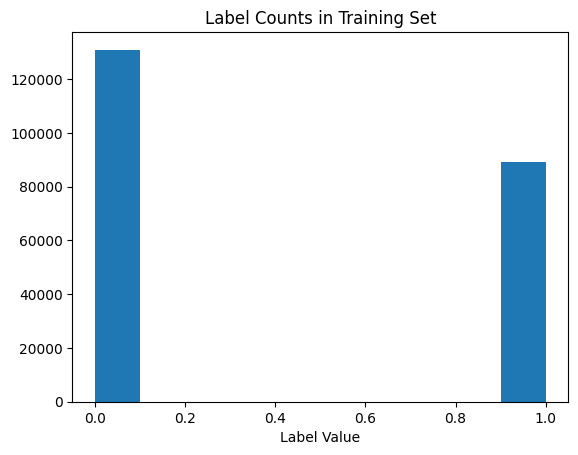

In [4]:
## Start by looking at class counts in label dataframe

print(label_df.head())

plt.hist(label_df.iloc[:,1])
plt.title('Label Counts in Training Set')
plt.xlabel('Label Value')

print(np.bincount(np.array(label_df.iloc[:,1])))

In the training set, there are 89,117 images with some cancer tissue and 130,908 clean images. This equates to 40.5% cancerous (positive) samples. This is a relatively balanced breakout of positive vs. negative, so to begin I will leave the dataset as-is, and explore re-balancing to a 50-50 split later if it improves model performance.


I am going to look at a few of the images and their corresponding labels to see what the micrographs look like, as well as check that the array conversion was successful. Each of the images is 96 x 96 pixels, with 3 channels for RGB.

In [7]:
print(train_df.shape, test_df.shape, label_df.shape)

(220025, 96, 96, 3) (57458, 96, 96, 3) (220025, 2)


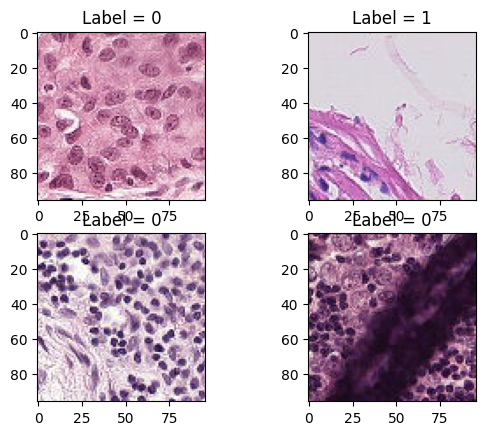

In [16]:
## Check out sample images

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(Image.fromarray(train_df[0]))
axarr[0,0].title.set_text(f'Label = {label_df.iloc[0,1]}')
axarr[0,1].imshow(Image.fromarray(train_df[1]))
axarr[0,1].title.set_text(f'Label = {label_df.iloc[1,1]}')
axarr[1,0].imshow(Image.fromarray(train_df[2]))
axarr[1,0].title.set_text(f'Label = {label_df.iloc[2,1]}')
axarr[1,1].imshow(Image.fromarray(train_df[3]))
axarr[1,1].title.set_text(f'Label = {label_df.iloc[3,1]}')

In [19]:
## View the first line of the first array image

train_df[0][0][0]

## This shows RGB values stored in 1-255 scale

array([241, 246, 250], dtype=uint8)

Now that we know the images have been correctly translated to the ndarray and taken a look at a few, it is time to build a model to classify the micrographs.

### Model Building

For the first model iteration, I am going to rescale the data to 0-1 instead of 0-255. Then, I am going to build a sequential model consisting of 2D convolutional layers with 2D pooling layers in between. At the end, I will output a dense layer with 2 output perceptrons to represent the probability of the image being class 0 or 1.

To start, I will use a filter size of (3x3) on each layer, with a 15-30-15 filter strategy. Each convolutional layer will use a Leaky ReLu activation function to help stabilize the results. The model will be compiled using the default 'Adam' optimizer and Sparse Categorical Cross Entropy loss function.

I think this strategy is suitable for image classification because it is similar to the repeating convolutional & pooling units that are seen in the VGGNet architecture.

In [4]:
## Create a sequential model, starting with a scaling step
shape = train_df[0].shape

model = keras.models.Sequential()

model.add(keras.layers.Rescaling(scale = 1./255., input_shape = shape))

# Next add the first convolution layer: 2 filters of 3x3, stride = 2
model.add(keras.layers.Conv2D(filters = 15,
                             kernel_size = (3,3),
                             strides = 1,
                             activation = 'LeakyReLU',
                             input_shape = shape))

#model.summary()

# Now add a pooling layer
model.add(keras.layers.MaxPooling2D(pool_size = (2,2)))
          
# Convolve again, 3 filters
model.add(keras.layers.Conv2D(filters = 30,
                             kernel_size = (3,3),
                             strides = 2,
                             activation = 'LeakyReLU',
                             padding = 'same'))

# Second pooling
model.add(keras.layers.MaxPooling2D(pool_size = (2,2)))

# Last convolution, 2 filters, single stride
model.add(keras.layers.Conv2D(filters = 15,
                             kernel_size = (3,3),
                             strides = 1,
                             activation = 'LeakyReLU',
                             padding = 'same'))

# Reduce to single dimension
model.add(keras.layers.Flatten())

# Add in Dense layer to start filtering down
model.add(keras.layers.Dense(15, activation='LeakyReLU'))

#model.add(keras.layers.Dropout(0.3))

# Output layer has 1 value, 0 or 1
#model.add(keras.layers.Dense(1, activation='sigmoid'))
model.add(keras.layers.Dense(2))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 15)        420       
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 15)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 30)        4080      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 30)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 15)        4

In [5]:
## Compile model
model.compile(optimizer = 'adam',
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
             metrics = ['accuracy'])

## Save weights to compare apples to apples with different fit strategies
model.save_weights('/kaggle/working/weights1.h5')

In [6]:
## Train first model

hist1 = model.fit(x = train_df,
                  y = label_df['label'],
                  batch_size=256, 
                  epochs=15)

Epoch 1/15
860/860 [==============================] - 22s 15ms/step - loss: 0.6761 - accuracy: 0.5949
Epoch 2/15
860/860 [==============================] - 13s 15ms/step - loss: 0.6750 - accuracy: 0.5950
Epoch 3/15
860/860 [==============================] - 13s 15ms/step - loss: 0.6745 - accuracy: 0.5950
Epoch 4/15
860/860 [==============================] - 13s 15ms/step - loss: 0.6736 - accuracy: 0.5951
Epoch 5/15
860/860 [==============================] - 13s 15ms/step - loss: 0.6722 - accuracy: 0.5953
Epoch 6/15
860/860 [==============================] - 13s 15ms/step - loss: 0.6704 - accuracy: 0.5965
Epoch 7/15
860/860 [==============================] - 13s 15ms/step - loss: 0.6685 - accuracy: 0.5989
Epoch 8/15
860/860 [==============================] - 13s 15ms/step - loss: 0.6661 - accuracy: 0.6010
Epoch 9/15
860/860 [==============================] - 13s 15ms/step - loss: 0.6639 - accuracy: 0.6031
Epoch 10/15
860/860 [==============================] - 13s 15ms/step - loss: 0.661

Text(0.5, 1.0, 'Accuracy vs. Epochs for Model 1')

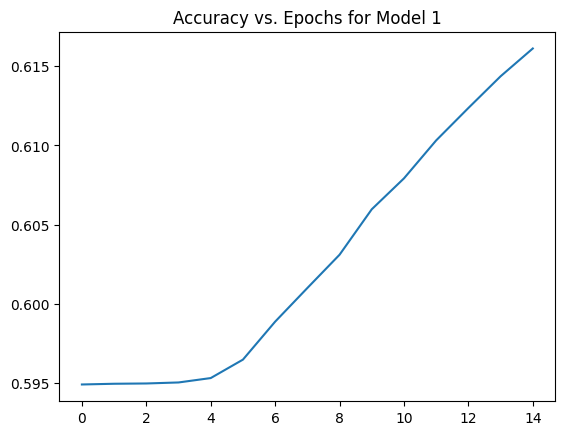

In [7]:
# Save hist due to ram limitations
np.save('/kaggle/working/hist1', np.asarray(hist1.history))

## Plot accuracy vs. epochs
plt.plot(hist1.history['accuracy'])
plt.title('Accuracy vs. Epochs for Model 1')

It appears like the training was stopped too soon because a plateau was not reached. It looks like the model takes awhile to start fitting, so I am going to set ema_momentum = True for the Adam optimizer, and change epochs to 20 to allow for a longer learning time.

In [9]:
# Load weights from before training to compare apples to apples
model.load_weights('/kaggle/working/weights1.h5')

## recompile with updates
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001, ema_momentum = True),
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
             metrics = ['accuracy'])

hist2 = model.fit(x = train_df,
    y = label_df['label'],
          batch_size=256, 
          epochs=20)

np.save('/kaggle/working/hist2', np.asarray(hist2.history))

Epoch 1/20
860/860 [==============================] - 14s 14ms/step - loss: 0.6761 - accuracy: 0.5947
Epoch 2/20
860/860 [==============================] - 12s 14ms/step - loss: 0.6751 - accuracy: 0.5950
Epoch 3/20
860/860 [==============================] - 12s 14ms/step - loss: 0.6746 - accuracy: 0.5950
Epoch 4/20
860/860 [==============================] - 13s 15ms/step - loss: 0.6738 - accuracy: 0.5949
Epoch 5/20
860/860 [==============================] - 12s 14ms/step - loss: 0.6725 - accuracy: 0.5954
Epoch 6/20
860/860 [==============================] - 12s 14ms/step - loss: 0.6708 - accuracy: 0.5963
Epoch 7/20
860/860 [==============================] - 12s 14ms/step - loss: 0.6686 - accuracy: 0.5977
Epoch 8/20
860/860 [==============================] - 12s 14ms/step - loss: 0.6663 - accuracy: 0.6003
Epoch 9/20
860/860 [==============================] - 12s 14ms/step - loss: 0.6638 - accuracy: 0.6032
Epoch 10/20
860/860 [==============================] - 12s 14ms/step - loss: 0.661

Text(0.5, 1.0, 'Accuracy vs. Epochs for Model1 vs Model2')

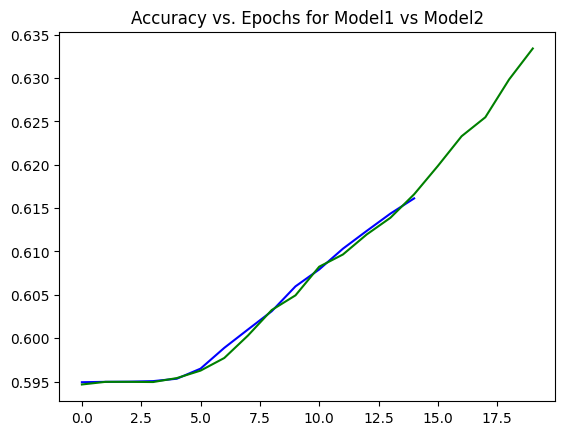

In [10]:
## Plot accuracy vs. epochs
plt.plot(hist1.history['accuracy'], color = 'blue')
plt.plot(hist2.history['accuracy'], color = 'green')
plt.title('Accuracy vs. Epochs for Model1 vs Model2')

After 20 epochs, the model accuracy continues to increase. It does not look like there is a large difference in using the momentum term through the first 15 epochs. 

I am going to try to speed up convergence by using a learning rate of 0.003 and increasing the batch size to 400.

In [5]:
model.load_weights('/kaggle/working/weights1.h5')

## recompile with updates
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.003, ema_momentum = True),
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
             metrics = ['accuracy'])

hist3 = model.fit(x = train_df,
    y = label_df['label'],
          batch_size=400, 
          epochs=20)

np.save('/kaggle/working/hist3', np.asarray(hist3.history))

Epoch 1/20
551/551 [==============================] - 20s 21ms/step - loss: 0.6785 - accuracy: 0.5931
Epoch 2/20
551/551 [==============================] - 12s 21ms/step - loss: 0.6753 - accuracy: 0.5949
Epoch 3/20
551/551 [==============================] - 12s 21ms/step - loss: 0.6751 - accuracy: 0.5950
Epoch 4/20
551/551 [==============================] - 12s 21ms/step - loss: 0.6748 - accuracy: 0.5950
Epoch 5/20
551/551 [==============================] - 12s 21ms/step - loss: 0.6744 - accuracy: 0.5951
Epoch 6/20
551/551 [==============================] - 12s 21ms/step - loss: 0.6736 - accuracy: 0.5952
Epoch 7/20
551/551 [==============================] - 12s 21ms/step - loss: 0.6728 - accuracy: 0.5951
Epoch 8/20
551/551 [==============================] - 12s 21ms/step - loss: 0.6718 - accuracy: 0.5954
Epoch 9/20
551/551 [==============================] - 12s 21ms/step - loss: 0.6709 - accuracy: 0.5962
Epoch 10/20
551/551 [==============================] - 12s 21ms/step - loss: 0.669

Text(0.5, 1.0, 'Accuracy vs. Epochs for Models 1-3')

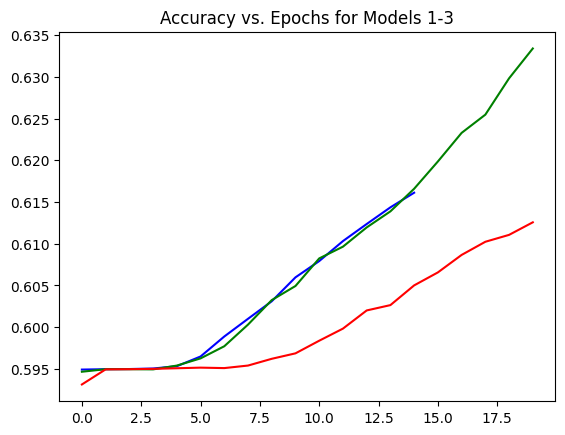

In [13]:
hist1 = np.load('/kaggle/working/hist1.npy', allow_pickle = True)
hist2 = np.load('/kaggle/working/hist2.npy', allow_pickle = True)

## Plot accuracy vs. epochs
plt.plot(hist1.item()['accuracy'], color = 'blue')
plt.plot(hist2.item()['accuracy'], color = 'green')
plt.plot(hist3.history['accuracy'], color = 'red')
plt.title('Accuracy vs. Epochs for Models 1-3')

The third iteration, using lr = 0.003 and batch size = 400 definitely did not help. I will go back to the second iteration, and try adding 5 more filters to each layer.

In [14]:
## Create a sequential model, starting with a scaling step
shape = train_df[0].shape

model2 = keras.models.Sequential()

model2.add(keras.layers.Rescaling(scale = 1./255., input_shape = shape))

# Next add the first convolution layer: 2 filters of 3x3, stride = 2
model2.add(keras.layers.Conv2D(filters = 20,
                             kernel_size = (3,3),
                             strides = 1,
                             activation = 'LeakyReLU',
                             input_shape = shape))

# Now add a pooling layer
model2.add(keras.layers.MaxPooling2D(pool_size = (2,2)))
          
# Convolve again, 3 filters
model2.add(keras.layers.Conv2D(filters = 35,
                             kernel_size = (3,3),
                             strides = 2,
                             activation = 'LeakyReLU',
                             padding = 'same'))

# Second pooling
model2.add(keras.layers.MaxPooling2D(pool_size = (2,2)))

# Last convolution, 2 filters, single stride
model2.add(keras.layers.Conv2D(filters = 20,
                             kernel_size = (3,3),
                             strides = 1,
                             activation = 'LeakyReLU',
                             padding = 'same'))

# Reduce to single dimension
model2.add(keras.layers.Flatten())

# Add in Dense layer to start filtering down
model2.add(keras.layers.Dense(20, activation='LeakyReLU'))

# Output layer has 1 value, 0 or 1
model2.add(keras.layers.Dense(2))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 94, 94, 20)        560       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 47, 47, 20)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 35)        6335      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 12, 12, 35)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 20)       

In [17]:
## Compile model
model2.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001, ema_momentum = True),
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
             metrics = ['accuracy'])

## Save weights to compare apples to apples with different fit strategies
model2.save_weights('/kaggle/working/weights2.h5')

hist4 = model2.fit(x = train_df,
    y = label_df['label'],
          batch_size=256, 
          epochs=20)

np.save('/kaggle/working/hist4', np.asarray(hist4.history))

Epoch 1/20
860/860 [==============================] - 17s 17ms/step - loss: 0.6762 - accuracy: 0.5940
Epoch 2/20
860/860 [==============================] - 15s 17ms/step - loss: 0.6751 - accuracy: 0.5950
Epoch 3/20
860/860 [==============================] - 15s 17ms/step - loss: 0.6748 - accuracy: 0.5949
Epoch 4/20
860/860 [==============================] - 15s 17ms/step - loss: 0.6739 - accuracy: 0.5950
Epoch 5/20
860/860 [==============================] - 15s 17ms/step - loss: 0.6724 - accuracy: 0.5963
Epoch 6/20
860/860 [==============================] - 15s 17ms/step - loss: 0.6703 - accuracy: 0.5979
Epoch 7/20
860/860 [==============================] - 15s 17ms/step - loss: 0.6679 - accuracy: 0.6003
Epoch 8/20
860/860 [==============================] - 15s 17ms/step - loss: 0.6648 - accuracy: 0.6035
Epoch 9/20
860/860 [==============================] - 15s 17ms/step - loss: 0.6617 - accuracy: 0.6066
Epoch 10/20
860/860 [==============================] - 15s 17ms/step - loss: 0.658

Text(0.5, 1.0, 'Accuracy vs. Epochs for Models 1-4')

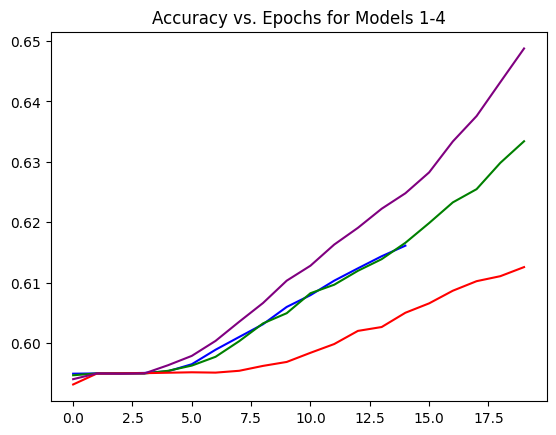

In [18]:
#hist1 = np.load('/kaggle/working/hist1.npy', allow_pickle = True)
#hist2 = np.load('/kaggle/working/hist2.npy', allow_pickle = True)

## Plot accuracy vs. epochs
plt.plot(hist1.item()['accuracy'], color = 'blue')
plt.plot(hist2.item()['accuracy'], color = 'green')
plt.plot(hist3.history['accuracy'], color = 'red')
plt.plot(hist4.history['accuracy'], color = 'purple')
plt.title('Accuracy vs. Epochs for Models 1-4')

The latest model is definitely the best so far, with just increasing the number of filters by 5 at each layer. Lastly, I am going to add another 5 filters to each layer, as well as normalize after each hidden pooling or dense layer.

In [4]:
## Create a sequential model, starting with a scaling step
shape = train_df[0].shape

model3 = keras.models.Sequential()

model3.add(keras.layers.Rescaling(scale = 1./255., input_shape = shape))

# Next add the first convolution layer: 2 filters of 3x3, stride = 2
model3.add(keras.layers.Conv2D(filters = 25,
                             kernel_size = (3,3),
                             strides = 1,
                             activation = 'LeakyReLU',
                             input_shape = shape))

# Now add a pooling layer
model3.add(keras.layers.MaxPooling2D(pool_size = (2,2)))

# Normalize
model3.add(keras.layers.BatchNormalization())
          
# Convolve again, 3 filters
model3.add(keras.layers.Conv2D(filters = 40,
                             kernel_size = (3,3),
                             strides = 2,
                             activation = 'LeakyReLU',
                             padding = 'same'))

# Second pooling
model3.add(keras.layers.MaxPooling2D(pool_size = (2,2)))

# Normalize
model3.add(keras.layers.BatchNormalization())

# Last convolution, 2 filters, single stride
model3.add(keras.layers.Conv2D(filters = 25,
                             kernel_size = (3,3),
                             strides = 1,
                             activation = 'LeakyReLU',
                             padding = 'same'))

# Normalize
model3.add(keras.layers.BatchNormalization())

# Reduce to single dimension
model3.add(keras.layers.Flatten())

# Add in Dense layer to start filtering down
model3.add(keras.layers.Dense(20, activation='LeakyReLU'))

# Normalize
model3.add(keras.layers.BatchNormalization())

# Output layer has 1 value, 0 or 1
model3.add(keras.layers.Dense(2))

model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 25)        700       
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 25)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 47, 47, 25)        100       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 40)        9040      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 40)        0

In [5]:
## Compile model
model3.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001, ema_momentum = True),
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
             metrics = ['accuracy'])

## Save weights to compare apples to apples with different fit strategies
model3.save_weights('/kaggle/working/weights3.h5')

hist5 = model3.fit(x = train_df,
    y = label_df['label'],
          batch_size=256, 
          epochs=20)

np.save('/kaggle/working/hist5', np.asarray(hist5.history))

Epoch 1/20
860/860 [==============================] - 30s 23ms/step - loss: 0.6789 - accuracy: 0.5918
Epoch 2/20
860/860 [==============================] - 20s 23ms/step - loss: 0.6755 - accuracy: 0.5946
Epoch 3/20
860/860 [==============================] - 20s 23ms/step - loss: 0.6750 - accuracy: 0.5946
Epoch 4/20
860/860 [==============================] - 20s 23ms/step - loss: 0.6741 - accuracy: 0.5945
Epoch 5/20
860/860 [==============================] - 20s 23ms/step - loss: 0.6725 - accuracy: 0.5956
Epoch 6/20
860/860 [==============================] - 20s 23ms/step - loss: 0.6699 - accuracy: 0.5973
Epoch 7/20
860/860 [==============================] - 20s 23ms/step - loss: 0.6662 - accuracy: 0.6006
Epoch 8/20
860/860 [==============================] - 20s 23ms/step - loss: 0.6622 - accuracy: 0.6068
Epoch 9/20
860/860 [==============================] - 20s 23ms/step - loss: 0.6585 - accuracy: 0.6104
Epoch 10/20
860/860 [==============================] - 20s 23ms/step - loss: 0.654

Text(0.5, 1.0, 'Accuracy vs. Epochs for Models 1-5')

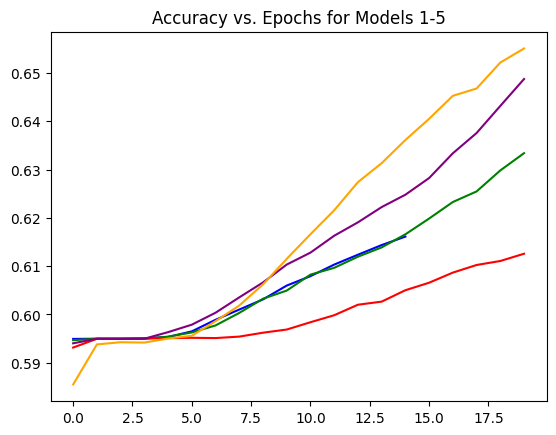

In [21]:
## Plot accuracy vs. epochs
plt.plot(hist1.item()['accuracy'], color = 'blue')
plt.plot(hist2.item()['accuracy'], color = 'green')
plt.plot(hist3.history['accuracy'], color = 'red')
plt.plot(hist4.history['accuracy'], color = 'purple')
plt.plot(hist5.history['accuracy'], color = 'orange')
plt.title('Accuracy vs. Epochs for Models 1-5')

The last model was the best that was tested, though notably slower than Model 4. At this point, I will do another 10 epochs of training on that model, then submit to Kaggle for results. The summary of training results so far is:


|Model Number | Filter Counts | Optimizer | Batch Size | Epochs | Final Accuracy |
| ----------- | --------------| --------- | ---------- | ------ | -------------- |
| 1 | 15, 30, 15 | Adam, 0.001 LR | 256 | 15 | 0.6161 |
| 2 | 15, 30, 15 | Adam, 0.001 LR, mom = T | 256 | 20 | 0.6334 |
| 3 | 15, 30, 15 | Adam, 0.003 LR | 400 | 20 | 0.6126 |
| 4 | 20, 35, 20 | Adam, 0.001 LR | 256 | 20 | 0.6488 |
| 5 | 25, 40, 25 | Adam, 0.001 LR | 256 | 20 | 0.6498 |

In [9]:
final_hist = model3.fit(x = train_df,
                        y = label_df['label'],
                        batch_size=256,
                        epochs=10)

Epoch 1/10
860/860 [==============================] - 20s 23ms/step - loss: 0.6194 - accuracy: 0.6514
Epoch 2/10
860/860 [==============================] - 20s 23ms/step - loss: 0.6171 - accuracy: 0.6553
Epoch 3/10
860/860 [==============================] - 20s 23ms/step - loss: 0.6145 - accuracy: 0.6567
Epoch 4/10
860/860 [==============================] - 20s 23ms/step - loss: 0.6121 - accuracy: 0.6593
Epoch 5/10
860/860 [==============================] - 20s 23ms/step - loss: 0.6096 - accuracy: 0.6620
Epoch 6/10
860/860 [==============================] - 20s 23ms/step - loss: 0.6074 - accuracy: 0.6641
Epoch 7/10
860/860 [==============================] - 20s 24ms/step - loss: 0.6049 - accuracy: 0.6658
Epoch 8/10
860/860 [==============================] - 20s 23ms/step - loss: 0.6028 - accuracy: 0.6673
Epoch 9/10
860/860 [==============================] - 20s 23ms/step - loss: 0.6001 - accuracy: 0.6704
Epoch 10/10
860/860 [==============================] - 20s 23ms/step - loss: 0.597

### Training Summary

Overall, I found that increasing the number of filters and epochs were the most successful improvements to the training accuracy. Attempting to speed up convergence with larger batch sizes and learning rates led to decreased performance, though they may work better with a different Optimizer like RMSProp or SGD. This model certainly still has room for improvement, but final accuracies were improved by about 6% through hyperparameter tuning.

**Predict Classification on Test Images**

In [10]:
test_pred = model3.predict(x = test_df, batch_size = 256)

225/225 [==============================] - 2s 9ms/step


In [13]:
## Now I need to get the index of the maximum value for each output

test_classes = np.argmax(test_pred, axis = -1)

test_classes[0:10]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 1])

In [20]:
## Join test predictions with test ids to match sample submission

sample_df.head()



,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [ ]:
## Get all ids
import os

test_images_lst = [file for file in os.listdir('/kaggle/input/histopathologic-cancer-detection/test')]

In [18]:
test_images_ids = []

for file in test_images_lst:
    test_images_ids.append(file.replace('.tif', ''))

In [21]:
test_submission = pd.DataFrame(data = {'id' : test_images_ids,
                                      'label' : test_classes})

In [22]:
test_submission.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,1
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,0
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0


In [25]:
## Write test submission to csv so that I can submit to challenge

test_submission.to_csv('/kaggle/working/test_submission.csv', index = False)